# Imports

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

import numpy as np
import pandas as pd
import random
import os

from tqdm import tqdm

import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
import torch.utils.data as data
import torchvision.datasets
from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, precision_recall_fscore_support

from scipy.stats import binomtest
from scipy.stats import norm

from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights

import matplotlib.pyplot as plt
from PIL import ImageOps, Image

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# device = 'cpu' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Paths to data
kkanji_150_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_150"
kkanji_200_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_200"
kkanji_300_path = "/mnt/d/Bachelor_work/data_for_model/kkanji2_300"

# Preact block

In [5]:
class PreactBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(PreactBasicBlock, self).__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')

        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")

        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)

        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):

        identity = x

        out = self.bn1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity

        return out

# Dataloader

In [6]:
def get_dataloaders(batch_size: int = 16, classamount: int = 150, train_test_indices_path: str = None):
    # Define transformations
    my_transform = transforms.Compose([
                transforms.Grayscale(num_output_channels=3),
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)
            ])

    if classamount == 150:
        # Load dataset 150
        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=my_transform)

    elif classamount == 200:
        # Load dataset 200
        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=my_transform)

    elif classamount == 300:
        # Load dataset 300
        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=my_transform)

    train_indices = []
    test_indices = []
    # Split dataset into training and testing sets

    if train_test_indices_path is not None and os.path.exists(train_test_indices_path):
        with open(train_test_indices_path, "rb") as f:
            indices = pickle.load(f)
            train_indices = indices["train_indices"]
            test_indices = indices["test_indices"]
                
    else:    
        train_indices, test_indices = train_test_split(
            list(range(len(full_dataset))),
            test_size=0.3,
            stratify=[label for _, label in full_dataset.samples]
        )
        
        # Save indices
        with open(train_test_indices_path, "wb") as f:
            pickle.dump({"train_indices": train_indices, "test_indices": test_indices}, f)

    train_dataset = data.Subset(full_dataset, train_indices)
    test_dataset = data.Subset(full_dataset, test_indices)

    # Calculate class weights for the training set
    class_counts = [0] * len(full_dataset.classes)

    for idx in train_indices:
        _, label = full_dataset.samples[idx]
        class_counts[label] += 1

    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]

    # Create a WeightedRandomSampler for the training set
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset

# Setup model and dataloaders

In [6]:
# Setup model and dataloaders
model_path = "/mnt/d/Bachelor_work/data_for_model/model_pretrained_unfreeze_all_300_stuff/model.pth"

model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, progress=False)
model.fc = nn.Linear(model.fc.in_features, 300)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    print("Model path does not exist, using default weights")
model = model.to(device)
trainloader, testloader, full_dataset = get_dataloaders(batch_size=16, classamount=300, train_test_indices_path="/mnt/d/Bachelor_work/data_for_model/train_test_indices_300.pkl")


/tmp/ipykernel_160113/880595771.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [14]:
# Create a confusion matrix between the two classes
def create_confusion_matrix(model, testloader, class1_idx, class2_idx):
    model.eval()
    confusion_matrix = np.zeros((2, 2), dtype=int)

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for i in range(labels.size(0)):
                true_label = labels[i].item()
                pred_label = preds[i].item()

                if true_label == class1_idx or true_label == class2_idx:
                    # True label
                    row = 0 if true_label == class1_idx else 1

                    # Only care if prediction is one of the two classes
                    if pred_label == class1_idx:
                        col = 0
                    elif pred_label == class2_idx:
                        col = 1
                    else:
                        continue  # skip irrelevant predictions

                    confusion_matrix[row][col] += 1

    return confusion_matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # Save the plot. Don't use imshow
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Add number of samples in each cell
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            plt.text(j, i, cm[i][j], ha='center', va='center', color='white' if cm[i][j] > cm.max()/2 else 'black')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix_between_来_and_來.png')

Evaluating:   0%|          | 0/1714 [00:00<?, ?it/s]

Confusion Matrix:
[[48 19]
 [14 64]]


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 20358 (\N{CJK UNIFIED IDEOGRAPH-4F86}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20358 (\N{CJK UNIFIED IDEOGRAPH-4F86}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


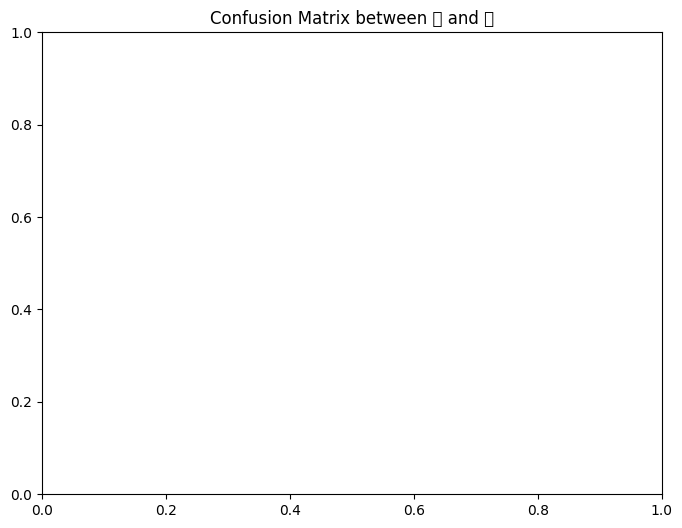

In [ ]:
# Define class labels
unicode_class1 = 'U+6765'  # Folder name for U+6765, 来
unicode_class2 = 'U+4F86'  # Folder name for U+4F86, 來

# Map class labels to indices using full_dataset.class_to_idx
class1 = full_dataset.class_to_idx[unicode_class1]
class2 = full_dataset.class_to_idx[unicode_class2]

# Call and plot the confusion matrix
confusion_matrix = create_confusion_matrix(model, testloader, class1, class2)
print("Confusion Matrix:")
print(confusion_matrix)

/tmp/ipykernel_160113/1424875319.py:45: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_160113/1424875319.py:45: UserWarning: Glyph 20358 (\N{CJK UNIFIED IDEOGRAPH-4F86}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_160113/1424875319.py:48: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix_between_来_and_來.png')
/tmp/ipykernel_160113/1424875319.py:48: UserWarning: Glyph 20358 (\N{CJK UNIFIED IDEOGRAPH-4F86}) missing from font(s) DejaVu Sans.
  plt.savefig('confusion_matrix_between_来_and_來.png')
/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/beav3r/Bachelor_work/bachelor_env/lib/python3.10/site-packages/IPython/core/pylab

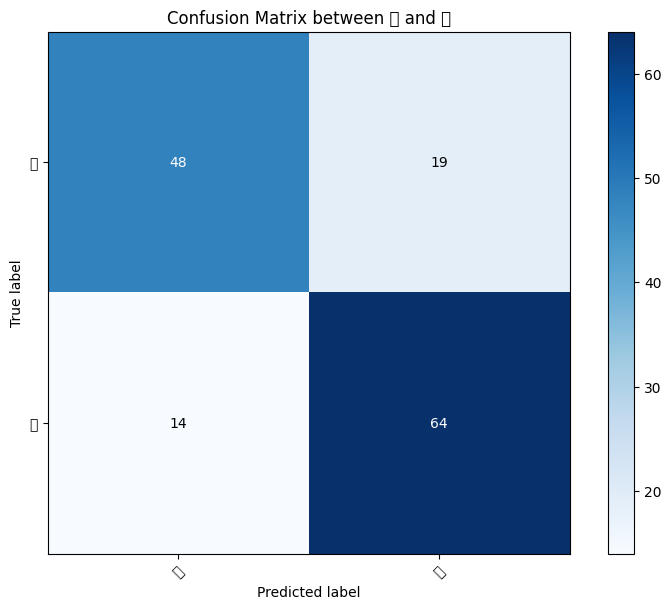

In [16]:
plot_confusion_matrix(
    confusion_matrix,
    classes=['来', '來'],
    title='Confusion Matrix between 来 and 來'
)

# Confindence interval and p-value

In [7]:
# Dataloaders for 150 classes
trainloader_150, testloader_150, full_dataset_150 = get_dataloaders(batch_size=16, classamount=150, train_test_indices_path="/mnt/d/Bachelor_work/data_for_model/train_test_indices_150.pkl")

In [8]:
# Dataloaders for 200 classes
trainloader_200, testloader_200, full_dataset_200 = get_dataloaders(batch_size=16, classamount=200, train_test_indices_path="/mnt/d/Bachelor_work/data_for_model/train_test_indices_200.pkl")

In [9]:
# Dataloaders for 300 classes
trainloader_300, testloader_300, full_dataset_300 = get_dataloaders(batch_size=16, classamount=300, train_test_indices_path="/mnt/d/Bachelor_work/data_for_model/train_test_indices_300.pkl")

In [15]:
# n_samples for 150, 200, 300
n_samples_150 = len(testloader_150.dataset)
n_samples_200 = len(testloader_200.dataset)
n_samples_300 = len(testloader_300.dataset)

print(f"Number of samples in 150 classes: {n_samples_150}")
print(f"Number of samples in 200 classes: {n_samples_200}")
print(f"Number of samples in 300 classes: {n_samples_300}")

# Accuracies
acc_baseline_150 = 0.9643
acc_mine_150 = 0.9794
acc_mine_200 = 0.9792
acc_mine_300 = 0.9762

Number of samples in 150 classes: 21180
Number of samples in 200 classes: 23708
Number of samples in 300 classes: 27418


In [19]:
def accuracy_significance_test(acc1, acc2, n_samples, alpha=0.05):
    """
    Test if accuracy difference is statistically significant
    acc1: accuracy of your model
    acc2: accuracy of baseline model
    n_samples: number of test samples
    """
    # Convert accuracies to counts
    correct1 = int(acc1 * n_samples)
    correct2 = int(acc2 * n_samples)
    
    # Perform binomial test
    p_value = binomtest(correct1, n=n_samples, p=acc2)
    print(f"Full info p-value: {p_value}")
    
    return {
        'p_value': p_value.pvalue,
        'significant': p_value.pvalue < alpha,
        'correct_predictions_yours': correct1,
        'correct_predictions_baseline': correct2
    }

In [25]:
result = accuracy_significance_test(
    acc1=acc_mine_150,  # Your model's accuracy
    acc2=acc_baseline_150,  # Baseline accuracy
    n_samples=n_samples_150  # Total test samples
)

print(f"p-value: {result['p_value']:.6f}")
print(f"Statistically significant: {result['significant']}")

Full info p-value: BinomTestResult(k=20743, n=21180, alternative='two-sided', statistic=0.9793673276676109, pvalue=2.0502465239492047e-37)
p-value: 0.000000
Statistically significant: True


In [21]:
def accuracy_confidence_interval(accuracy, n_samples, confidence=0.95):
    """
    Calculate confidence interval for accuracy
    """
    z = norm.ppf((1 + confidence) / 2)
    std_err = np.sqrt((accuracy * (1 - accuracy)) / n_samples)
    margin = z * std_err
    
    return (max(0, accuracy - margin), min(1, accuracy + margin))

In [24]:
# Example
# Calculate confidence intervals for your models, 150, 200, 300
ci_yours_150 = accuracy_confidence_interval(acc_mine_150, n_samples_150)
ci_yours_200 = accuracy_confidence_interval(acc_mine_200, n_samples_200)
ci_yours_300 = accuracy_confidence_interval(acc_mine_300, n_samples_300)
ci_baseline_150 = accuracy_confidence_interval(acc_baseline_150, n_samples_150)

print(f"Your model that classifies 150 classes: {acc_mine_150:.4f} (95% CI: {ci_yours_150[0]:.4f}-{ci_yours_150[1]:.4f})")
print(f"Your model that classifies 200 classes: {acc_mine_200:.4f} (95% CI: {ci_yours_200[0]:.4f}-{ci_yours_200[1]:.4f})")
print(f"Your model that classifies 300 classes: {acc_mine_300:.4f} (95% CI: {ci_yours_300[0]:.4f}-{ci_yours_300[1]:.4f})")
print(f"Baseline model that classifies 150 classes: {acc_baseline_150:.4f} (95% CI: {ci_baseline_150[0]:.4f}-{ci_baseline_150[1]:.4f})")

Your model that classifies 150 classes: 0.9794 (95% CI: 0.9775-0.9813)
Your model that classifies 200 classes: 0.9792 (95% CI: 0.9774-0.9810)
Your model that classifies 300 classes: 0.9762 (95% CI: 0.9744-0.9780)
Baseline model that classifies 150 classes: 0.9643 (95% CI: 0.9618-0.9668)
